## Construction with constraints

The answer is yes. 

In [21]:
import Pkg
Pkg.add("HiGHS")
Pkg.add("JuMP")
Pkg.add("NamedArrays")

   Resolving package versions...
  No Changes to `C:\Users\X\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\X\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\X\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\X\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\X\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\X\.julia\environments\v1.8\Manifest.toml`


In [22]:
using JuMP, HiGHS, NamedArrays
m = Model()

months = [1:4...]
projs = [1:3...]
needs = [8, 10, 12]

@variable(m, x[months,projs] >= 0)

@constraint(m, mon[i in months], sum(x[i,j] for j in projs) <= 8 )
@constraint(m, pro[j in projs], sum(x[i,j] for i in months) == needs[j] )
@constraint(m, sum(x[i,1] for i in [4:4...]) == 0)
@constraint(m, sum(x[i,3] for i in [3:4...]) == 0)

for i in months
    for j in projs
        @constraint(m, x[i,j] <= 6)
    end
end
        
@objective(m, Max, x[1,1])
set_optimizer(m, HiGHS.Optimizer)
optimize!(m)
solution = NamedArray( Int[value(x[i,j]) for i in months, j in projs], (months,projs), ("Month","Proj") )
println(solution)

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
7 rows, 9 cols, 18 nonzeros
5 rows, 7 cols, 13 nonzeros
Presolve : Reductions: rows 5(-16); columns 7(-5); elements 13(-26)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Ph1: 0(0) 0s
          5    -2.0000000000e+00 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 5
Objective value     :  2.0000000000e+00
HiGHS run time      :          0.00
4×3 Named Matrix{Int64}
Month ╲ Proj │ 1  2  3
─────────────┼────────
1            │ 2  0  6
2            │ 2  0  6
3            │ 4  4  0
4            │ 0  6  0


## Stigler Diet

### (a)

* The objective: $$~~\max_{r}~~sum(r_i),~~for~~i=1,...,77 $$
    which $r_i$ is the daily cost of each food, $r$ is the vector.

* The constraints: $$s.t.~~Ar\geq b~~$$ 

    $A$ is a matrix contains the nutrient content of 77 foods for 9 nutrients per 1 dollar. $b$ is a vector contains the minimum daily allowance of 9 nutrients. The size of $A$ can be 9x77 when $r$ is 77x1 and $b$ is 9x1.

* The decision variables is $r$, which contains the daily cost of 77 foods.

In [13]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")


   Resolving package versions...
  No Changes to `C:\Users\X\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\X\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\X\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\X\.julia\environments\v1.8\Manifest.toml`


In [1]:
# STARTER CODE FOR STIGLER'S DIET PROBLEM

using NamedArrays, CSV, DataFrames

# import Stigler's data set
raw = CSV.read("stigler.csv", DataFrame);
(m,n) = size(raw)

n_nutrients = 2:n      # columns containing nutrients
n_foods = 3:m          # rows containing food names

# list of food
foods = raw[2:end,1]
# list of nutrients
nutrients = [string(names(raw)[i]) for i=2:length(names(raw))]

# minimum required amount of each nutrient
lower = Dict( zip(nutrients,raw[1,n_nutrients]) )

# data[f,i] is the amount of nutrient i contained in food f 
dataraw = Matrix(values(raw[2:end,2:end]))
data = NamedArray(dataraw,(foods,nutrients),("foods","nutrients"))
                
        
# println(data[foods[1], nutrients[1]])
println("Foods:\n")
# for i in foods
#     println(i)
# end


println("\n\nNutrient Lower Bounds:\n")
for j in nutrients
    println(j," at least: ",lower[j])
end


Foods:



Nutrient Lower Bounds:

Calories (1000) at least: 3.0
Protein (g) at least: 70
Calcium (g) at least: 0.8
Iron (mg) at least: 12
Vitamin A (1000 IU) at least: 5.0
Thiamine (mg) at least: 1.8
Riboflavin (mg) at least: 2.7
Niacin (mg) at least: 18
Ascorbic Acid (mg) at least: 75


### (b)

In [4]:
using JuMP, HiGHS
m = Model()

@variable(m, cost[foods] >= 0 ) 

@expression(m, day_cost, sum(cost[i] for i in foods))  
@expression(m, day_nu[j in nutrients], sum(cost[i]*data[i,j] for i in foods))

for i in nutrients
    @constraint(m, day_nu[i] >= lower[i] ) 
end

@objective(m, Min, day_cost)
set_optimizer(m, HiGHS.Optimizer)
optimize!(m)
println("The the optimal daily cost is ", objective_value(m)*365)

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
9 rows, 40 cols, 317 nonzeros
9 rows, 27 cols, 213 nonzeros
Presolve : Reductions: rows 9(-0); columns 27(-50); elements 213(-357)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 9(76.4375) 0s
          5     1.0866227821e-01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 5
Objective value     :  1.0866227821e-01
HiGHS run time      :          0.00
The the optimal daily cost is 39.661731545466246


### (c)

In [7]:
for i in nutrients
    println(i , ": ", value.(day_nu)[i]*365)
end

Calories (1000): 1095.0
Protein (g): 53805.9402539063
Calcium (g): 292.0
Iron (mg): 22070.426567133854
Vitamin A (1000 IU): 1825.0
Thiamine (mg): 1503.960163766097
Riboflavin (mg): 985.5000000000001
Niacin (mg): 9970.332955605238
Ascorbic Acid (mg): 27375.0


In [84]:
for i in nutrients
    j = 0
    if abs(value.(lower[i]) - value.(day_nu[i])) < 1e-2
        j = 1
    end
    println(i,": lower bound is ",value.(lower[i]),", the amount of nutrient is ", value.(day_nu[i]), ", is dual (1 means yes) ", j )
end

Calories (1000): lower bound is 3.0, the amount of nutrient is 3.0, is dual (1 means yes) 1
Protein (g): lower bound is 70, the amount of nutrient is 147.41353494220905, is dual (1 means yes) 0
Calcium (g): lower bound is 0.8, the amount of nutrient is 0.8, is dual (1 means yes) 1
Iron (mg): lower bound is 12, the amount of nutrient is 60.466922101736586, is dual (1 means yes) 0
Vitamin A (1000 IU): lower bound is 5.0, the amount of nutrient is 5.0, is dual (1 means yes) 1
Thiamine (mg): lower bound is 1.8, the amount of nutrient is 4.120438804838622, is dual (1 means yes) 0
Riboflavin (mg): lower bound is 2.7, the amount of nutrient is 2.7, is dual (1 means yes) 1
Niacin (mg): lower bound is 18, the amount of nutrient is 27.31598070028832, is dual (1 means yes) 0
Ascorbic Acid (mg): lower bound is 75, the amount of nutrient is 75.0, is dual (1 means yes) 1


### (d)

In [69]:
using JuMP, HiGHS
m = Model()

@variable(m, cost[foods] >= 0 ) 

@expression(m, day_cost, sum(cost[i] for i in foods))  
@expression(m, day_nu[j in nutrients], sum(cost[i]*data[i,j] for i in foods))

for i in nutrients
    @constraint(m, day_nu[i] >= lower[i] ) 
end
@constraint(m, cost["Liver (Beef)"] == 0 ) 
@constraint(m, cost["Milk"] >= 0.01 ) 

@objective(m, Min, day_cost)
set_optimizer(m, HiGHS.Optimizer)
optimize!(m)
println("The the optimal daily cost is ", objective_value(m)*365)

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
9 rows, 40 cols, 315 nonzeros
9 rows, 28 cols, 220 nonzeros
Presolve : Reductions: rows 9(-2); columns 28(-49); elements 220(-352)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.0000006980e-02 Pr: 9(75.9634) 0s
          5     1.1194951710e-01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 5
Objective value     :  1.1194951710e-01
HiGHS run time      :          0.00
The the optimal daily cost is 40.86157374283626


In [73]:
for i in foods
    if value(cost[i]) > 0
        println(i,": the amount is ", value.(cost[i]))
    end
end
println("\nThe annual cost is ", objective_value(m)*365)

Wheat Flour (Enriched): the amount is 0.03569701410638522
Milk: the amount is 0.01
Evaporated Milk (can): the amount is 0.0021523432962831084
Cabbage: the amount is 0.010991091937036563
Spinach: the amount is 0.005114223881043092
Navy Beans, Dried: the amount is 0.047994843882913016

The annual cost is 40.86157374283626


## Museum site planning

### The mathematical model of this optimization problem:

Since the boundaries can be represented in a two-dimensional coordinate system as $$x = 0,\quad y = 0,\quad y = 500,\quad y+2/3x = 700,\quad y-3x = -1500 $$
The Chebyshev center problem can be formulated as the following linear program:

* The objective: $\max_{c,r} ~~r $

* The constraints: $s.t.~~a_jc + ||a_j||r\leq b_j,~~ for~~j=1,...,5$ 

    The vectors $a_j$ are the normal vector for each hyperplane and $b_j$ is the constant on the right hand side.
    $a_1 = [-1~~0],\\
a_2 = [0~~-1],\\
a_3 = [0~~1],\\
a_4 = [2/3~~1],\\
a_5 = [3~~-1],\\ 
b = [0~~0~~500~~700~~1500].\\
$

* The decision variables are $c, r$, while $c$ is the position of the center of circle, $r$ is the distance between $c$ and each boundary. 

In [6]:
using Pkg
Pkg.add("PyPlot")
Pkg.add("LinearAlgebra")

   Resolving package versions...
  No Changes to `C:\Users\X\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\X\.julia\environments\v1.8\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\X\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\X\.julia\environments\v1.8\Manifest.toml`


In [10]:
using JuMP, HiGHS, LinearAlgebra

A = [-1 0; 0 -1; 0 1; 2/3 1; 3 -1];
b = [0; 0; 500; 700; 1500]

m = Model()

@variable(m, r >= 0)
@variable(m, c[1:2]>=0)
for i = 1:size(A,1)
    @constraint(m, A[i,:]'*c + r*norm(A[i,:]) <= b[i])
end
@objective(m, Max, r)

set_optimizer(m, HiGHS.Optimizer)
optimize!(m)
println("Center is: ", value.(c))
println("The maximum radius is: ", value.(r-75))

Running HiGHS 1.4.0 [date: 1970-01-01, git hash: bcf6c0b22]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
5 rows, 3 cols, 12 nonzeros
5 rows, 3 cols, 12 nonzeros
Presolve : Reductions: rows 5(-0); columns 3(-0); elements 12(-0) - Not reduced
Problem not reduced by presolve: solving the LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -9.9999845409e-01 Ph1: 5(7.36413); Du: 1(0.999998) 0s
          4     2.4402852679e+02 Pr: 0(0) 0s
Model   status      : Optimal
Simplex   iterations: 4
Objective value     :  2.4402852679e+02
HiGHS run time      :          0.00
Center is: [244.02852679380192, 244.0285267938019]
The maximum radius is: 169.02852679380186


The center position is [244.02852679380192, 244.0285267938019].

The optimal radius is 169.02852679380186.

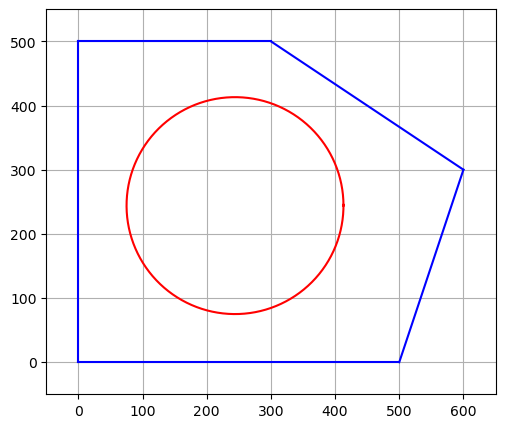

In [9]:
using PyPlot

# Defining a function to plot the outline of the museum area
function plot_site(mode)
    center = [244.02852679380192, 244.0285267938019]
    radius = 169.02852679380186
    theta = Array(0: 0.01: 2*pi+0.01)
    x = radius * cos.(theta) .+ center[1]
    y = radius * sin.(theta) .+ center[2]
    plot(x, y, "r-")
    
    plot([0,0], [0,500], "b-")
    plot([0,500], [0,0], "b-")
    plot([500,600], [0,300],"b-")
    plot([300,600], [500,300],"b-")
    plot([0,300], [500,500],"b-")
    axis("image")
    axis([-.5,6.5,-.5,5.5]*100)
    grid()
end

figure(figsize=(6,5))
plot_site(1)